# Prediction of customers' travel pattern

- Tune ML models
- Using Logistic Clf


- https://www.scikit-yb.org/en/latest/api/model_selection/importances.html

# 1)-Importing key modules

In [13]:
import warnings
warnings.filterwarnings('ignore')
# For processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from collections import Counter
import datetime as dt
from datetime import datetime
import seaborn as sns
from pprint import pprint
%matplotlib inline


In [14]:
# For modeling building and tunning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.under_sampling import NearMiss

In [15]:
# for evaluation

from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [16]:
from datetime import date
import datetime as dt

# 2)-Loading & Processing data

In [17]:
df = pd.read_csv('selected_feature.csv')
df.shape

(45805, 515)

In [18]:
df.head()

,event_type,distance,num_family,len_jour,ts_hour,origin_ADB,origin_ADL,origin_AER,origin_AGP,origin_AKL,...,dest_YEG,dest_YMQ,dest_YOW,dest_YTO,dest_YUL,dest_YVR,dest_YWG,dest_YYC,dest_YYZ,dest_ZRH
0,0,5834.154716,7,6.0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6525.926149,4,21.0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,469.781624,2,3.0,23,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1498.817537,1,3.0,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2921.339028,4,6.0,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_model=df.copy()

In [20]:
y=df_model["event_type"]
features=df_model.drop(['event_type'], axis=1)
X = StandardScaler().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
nm = NearMiss()
X_under,y_under=nm.fit_sample(X_train,y_train)
# Logistic Classifeir
logreg = LogisticRegression()
logreg.fit(X_under, y_under)
predictions_LR = logreg.predict(X_test)

# 3)-Evaluation 

In [21]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
print('Over-sampled dataset shape {}'.format(Counter(y_under)))

Original dataset shape Counter({0: 30780, 1: 1283})
Over-sampled dataset shape Counter({0: 1283, 1: 1283})


In [22]:
y_test.value_counts()

0    13217
1      525
Name: event_type, dtype: int64

In [23]:
print(X_test.shape)

(13742, 514)


In [24]:
print(accuracy_score(predictions_LR,y_test))

0.22165623635569787


In [25]:
print(classification_report(predictions_LR,y_test))

              precision    recall  f1-score   support

           0       0.20      0.95      0.33      2793
           1       0.74      0.04      0.07     10949

    accuracy                           0.22     13742
   macro avg       0.47      0.49      0.20     13742
weighted avg       0.63      0.22      0.12     13742



So far, I have used classification report to show results and kept "Precicision" for main matrics of evaluation. It is time to open bag and let "cat" out of it. **Why did I choose precision as matrics of evaluation for this very case?**

### 3.1)- Confusion matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
Key matrix elements are:

- true positives (TP): These are cases in which we predicted yes (booking events), and actually they do have booked events. 
- true negatives (TN): We predicted search events from customers,actually they were.
- false positives (FP): We predicted booking events from customers, but actually they were search ones. (Also known as a "Type I error.")
- false negatives (FN): We predicted search events.Those were rather booking event types. (Also known as a "Type II error.")

In [26]:
cm = confusion_matrix(predictions_LR,y_test)
cm

array([[ 2657,   136],
       [10560,   389]])

In [27]:
# slice confusion matrix into four pieces
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

In [28]:
P =(cm/cm.sum(axis=0))
P

array([[0.20102898, 0.25904762],
       [0.79897102, 0.74095238]])

We have 65 values where our model predicted loyal customers and they turned out to be staying customers .So good job!

We have 31 values where our model predicted non-leaving customers and they were actually churned ones. That's really uncool.

**We have 44 values where our model predicted churned customers. Actually those poor guys were loyal customers. Sorry !**

**We have 60 values where we predicted leaving customers and they actually were leaving.**

This is what matters for us. This is an important information



**Note**

We can imagine that our model does not look very accurate. Still we only made 60 right predictions regarding churned customers successfully.Also, we have made 65 right predictions about loyals ones.
We left out 44 churned ones. In real world if data was huge, that won't not really bad. But, we have a smaller dataset. 44 means 22% false positives.That's where accuracy matrics fails.
One issue with recall is that our model got very ideal situation where class of churned and loyal customer is almost same.Hence, we got pretty much same number i.e 60 for True positive and 65 True negatives.If classes were imbalanced then sensivity would be better idea.In our case, accuracy better idea.
If we tend to focus(as mentioned in excercise) more on our loyal customers than our churned ones then we need to check True positive and False negative results seriously.
Note that we are falsely predicting 31 loyal customers i.e 15.5% . An alarming %age even though our data is small yet we cannot be that wrong on our focussed segment
Those who are actually loyal to us is our concern and our prediction should get better results there.

### 3.2)- Precision vs recall

### back to classification report and result

# 3.GridSearchCV using Log Classifier Model

In [29]:
y=df_model["event_type"]
features=df_model.drop(['event_type'], axis=1)
X = StandardScaler().fit_transform(features)
nm = NearMiss()
X_under,y_under=nm.fit_sample(X,y)

In [30]:
lr = LogisticRegression(random_state=5, class_weight='balanced',penalty='l2')

In [31]:
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [33]:
grid_search = GridSearchCV(lr,param_grid, n_jobs=-1, scoring='precision', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=1.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=140, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
grid_search.best_score_

0.05385127794469115

In [35]:
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 1.5, 'dual': False, 'max_iter': 140}


In [36]:
grid_search.best_estimator_

LogisticRegression(C=1.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=140, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
grid_search.cv_results_

{'mean_fit_time': array([ 2.42501678,  2.39910145,  1.38195872,  0.69666715,  0.6878078 ,
        21.55131631, 22.98424788, 24.71438947, 26.72245636, 25.38598337,
         1.87476459,  1.06206074,  0.89632664,  0.81297584,  0.76201243,
        20.21713066, 21.68562355, 22.71631851, 23.09105458, 20.45520978,
         1.94356451,  1.26132193,  1.02560463,  0.95041313,  0.92613726,
        20.97500591, 22.29661164, 23.71980295, 24.76792064, 20.50431232,
         2.15832195,  1.29645987,  1.08808074,  0.93068333,  0.8577754 ,
        20.18643909, 22.02325315, 23.30978179, 24.41244411, 20.75534463]),
 'std_fit_time': array([0.10303809, 0.05360634, 0.80607727, 0.04388497, 0.05840529,
        0.32266278, 0.29356357, 0.56586446, 0.57319061, 3.16605216,
        0.26003092, 0.09942379, 0.0512189 , 0.02603588, 0.01701174,
        0.51434553, 0.63208785, 1.99925228, 1.79167306, 4.47890704,
        0.42992614, 0.19802588, 0.02728859, 0.01331069, 0.02115144,
        0.31411412, 0.33841328, 1.6305387

# 4)-predict_proba

In [38]:
grid_search.predict_proba(X_test)[0:10, :]

array([[0.47582436, 0.52417564],
       [0.7366389 , 0.2633611 ],
       [0.42185331, 0.57814669],
       [0.62896714, 0.37103286],
       [0.63085819, 0.36914181],
       [0.28081807, 0.71918193],
       [0.33328292, 0.66671708],
       [0.38498986, 0.61501014],
       [0.4870752 , 0.5129248 ],
       [0.59663543, 0.40336457]])

In [39]:
pred_prob_zero = grid_search.predict_proba(X_test)[:, 0]
print(pred_prob_zero[:5])

[0.47582436 0.7366389  0.42185331 0.62896714 0.63085819]


Text(0, 0.5, 'Frequency')

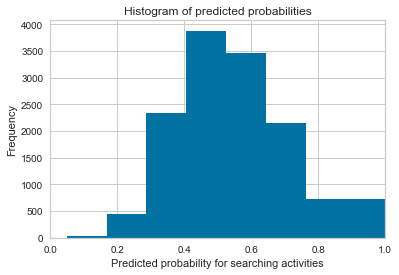

In [40]:
# histogram of predicted probabilities for search activities
plt.hist(pred_prob_zero, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for searching activities')
plt.ylabel('Frequency')

In [41]:
pred_prob_cl_one = grid_search.predict_proba(X_test)[:, 1]
print(pred_prob_cl_one[:5])

[0.52417564 0.2633611  0.57814669 0.37103286 0.36914181]


Text(0, 0.5, 'Frequency')

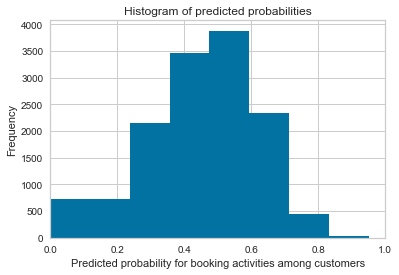

In [42]:
# histogram of predicted probabilities for churned customers
plt.hist(pred_prob_cl_one, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for booking activities among customers')
plt.ylabel('Frequency')

These are the probabilities that for booking and search acitivities among customers.

# 5)-ROC & AUC

In [43]:
from sklearn.metrics import roc_curve
roc_score=roc_curve(y_test, pred_prob_cl_one)

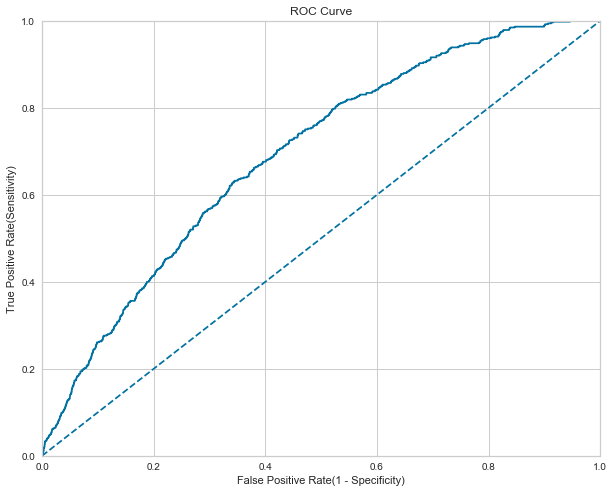

In [44]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, pred_prob_cl_one)


def _plot_roc_curve(fpr, tpr, thres):
    roc = plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', label = 'ROC')
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate(1 - Specificity)')
    plt.ylabel('True Positive Rate(Sensitivity)')
    plt.title('ROC Curve')
    return roc
p1 = _plot_roc_curve(fpr, tpr, thres)

In [45]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.692778276173903

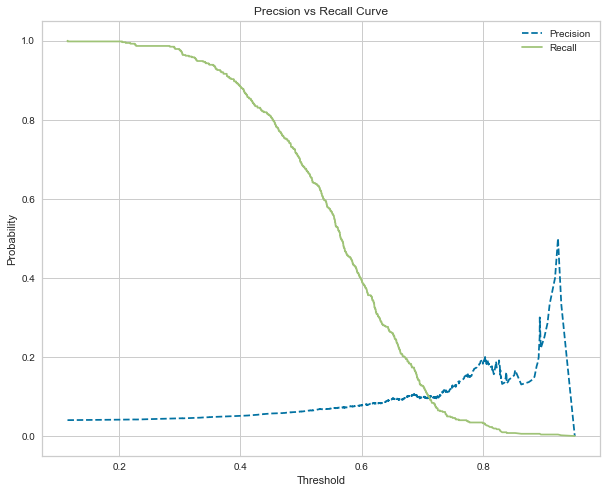

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve
prec, rec, thres = precision_recall_curve(y_test, pred_prob_cl_one)

def _plot_prec_rec_curve(prec, rec, thres):
    plot_pr = plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()
    #return plot_pr(it creates duplicate graph)

_plot_prec_rec_curve(prec, rec, thres)

Our threshold is almost at 0.5. If we go to lower values we can get better recall values. Higher values will improve precision but, recall will go very low. Model is still not giving best of result. But, this is better tha what we got

**END OF NOTEBOOK**